In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import random
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dot, Embedding, Flatten, Dense
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [2]:
# download and unzip the Cora graph from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
# It contains the graph in cora.cites and the node labels in cora.content
path = "/home/koki/Desktop/Data/Graphs/cora/cora.cites" # update the path 
f = open(path, "r")
G = nx.Graph()
for line in f:
    if line[0] == "#":
        continue
    line = line.strip()
    line_split = line.split("\t")
    try:
        u = int(line_split[0])
        v = int(line_split[1])
        G.add_edge(u, v)
    except:
        raise ValueError("Line cannot be processed: ", line)

In [3]:
G.number_of_nodes(), G.number_of_edges()

(2708, 5278)

In [4]:
def random_walk(G, u, k):
    curr_node = u
    walk = []
    for i in range(k):
        idx = random.randint(0,len(list(G[curr_node]))-1)
        curr_node = list(G[curr_node])[idx]
        walk.append(curr_node)
    return walk

In [5]:
random_walk(G, 1033, 5)

[1034, 1035, 1034, 1033, 45605]

In [8]:
# we need to work with consecutive integers for our embedding algorithm
# below we create two hash tables that map 
node_to_int = {}
int_to_node = {}
for i, u in enumerate(list(G.nodes())):
    node_to_int[u] = i
    int_to_node[i] = u

In [9]:
class RandomWalkGen(tf.keras.utils.Sequence):
    """
        A generator class that will feed positive and negative examples.
    """    
    
    def __init__(self, 
                 G, 
                 walk_length, 
                 node_to_int,
                 nr_neg_samples, 
                 nr_nn, batch_size):
        
        """
        Initialization
        :param G: the (undirected) input graph
        :param walk_length: the length of the random walk
        :param node_to_int: a mapping of node ids to integers
        :param nr_neg_samples: the number of negative samples for positive pair
        :param nr_nn: how many nearest neighbors per candidate to generate
        :param batch_size: how many samples to generate
        """
        self.G = G
        self.walk_length = walk_length
        self.node_to_int = node_to_int
        assert nr_neg_samples >= 1
        self.nr_neg_samples = nr_neg_samples # by how mach to multiply the number pf positive samples
        self.nr_nn = nr_nn
        self.batch_size = batch_size
        
         
    # how many samples to generate per epoch        
    def __len__(self):
        return 10000
    
    def __getitem__(self, idx):
        i = 0
        samples = []
        labels = []
        while i < self.batch_size:
            i += 1
            start = np.random.randint(self.G.number_of_nodes())
            u = list(self.G.nodes())[start]
            walk = self.random_walk(u)
            
            neg_idx = np.random.choice(self.G.number_of_nodes(), self.nr_neg_samples*self.walk_length)
            neg = [list(G.nodes())[idx] for idx in neg_idx]
            
            # generate positive samples from the random walk
            samples.extend([(self.node_to_int[u],self.node_to_int[p]) for p in walk])
            labels.extend(self.walk_length*[1])
            
            # generate negative samples, a multiple of the walk length
            samples.extend([(self.node_to_int[u], self.node_to_int[n]) for n in neg])
            labels.extend(self.nr_neg_samples*self.walk_length*[0])
        return np.array(samples), np.array(labels)
    
    def random_walk(self, u):
        curr_node = u
        walk = []
        for i in range(self.walk_length):
            idx = random.randint(0,len(list(self.G[curr_node]))-1)
            curr_node = list(self.G[curr_node])[idx]
            walk.append(curr_node)
        return walk


In [10]:
gen = RandomWalkGen(G, walk_length=5, node_to_int=node_to_int, 
                     nr_neg_samples=2, nr_nn=50, batch_size=1)

In [11]:
len(gen[10][0])

15

In [12]:
class Node2Vec(Model):
    """
    The discriminative model that trains node embeddings. 
    Essentially, this is word2vec with negative sampling.
    """
    def __init__(self, nr_nodes, embedding_dim, *args, **kwargs):
        super(Node2Vec, self).__init__(self, args, kwargs)
        self.nr_nodes = nr_nodes
        self.embedding_dim = embedding_dim
        self.target_embedding = Embedding(nr_nodes,
                                          embedding_dim,
                                          embeddings_initializer="RandomNormal",
                                          input_length=1,
                                          name="node_embedding")
        self.context_embedding = Embedding(nr_nodes,
                                           embedding_dim,
                                           embeddings_initializer="RandomNormal",
                                           input_length=1,
                                           name="context_embedding")
        self.dots = Dot(axes=1)
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, pair):
        target, context = pair[:,0], pair[:,1]
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = self.dots([context_emb, word_emb])
        flat = self.flatten(dots)
        return self.dense(flat)
    
    def summary(self):
        x = Input(shape=(2,))
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [13]:
# this is a small graph, so the embedding dimensionality can be also small 
embedding_dim = 20
nr_nodes = G.number_of_nodes()
n2v = Node2Vec(nr_nodes=nr_nodes, embedding_dim=embedding_dim)
n2v.build(input_shape=(nr_nodes, embedding_dim))
n2v.compile(optimizer='adam',
                 loss= 'binary_crossentropy', 
                 metrics=['accuracy', 'AUC'])

In [14]:
n2v.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None,)              0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None,)              0           input_1[0][0]                    
__________________________________________________________________________________________________
context_embedding (Embedding)   (None, 20)           54160       tf.__operators__.getitem_1[0][0] 
______________________________________________________________________________________________

In [15]:
n2v.fit(gen, epochs=10)

Epoch 1/10
10000/10000 [==============================] - 27s 3ms/step - loss: 0.6070 - accuracy: 0.6874 - auc: 0.6659
Epoch 2/10
10000/10000 [==============================] - 26s 3ms/step - loss: 0.4273 - accuracy: 0.8187 - auc: 0.8590
Epoch 3/10
10000/10000 [==============================] - 27s 3ms/step - loss: 0.3025 - accuracy: 0.8831 - auc: 0.9279
Epoch 4/10
10000/10000 [==============================] - 27s 3ms/step - loss: 0.2427 - accuracy: 0.9102 - auc: 0.9536
Epoch 5/10
10000/10000 [==============================] - 26s 3ms/step - loss: 0.2196 - accuracy: 0.9215 - auc: 0.9619
Epoch 6/10
10000/10000 [==============================] - 26s 3ms/step - loss: 0.2018 - accuracy: 0.9279 - auc: 0.9682
Epoch 7/10
10000/10000 [==============================] - 26s 3ms/step - loss: 0.1924 - accuracy: 0.9317 - auc: 0.9711
Epoch 8/10
10000/10000 [==============================] - 26s 3ms/step - loss: 0.1839 - accuracy: 0.9351 - auc: 0.9735
Epoch 9/10
10000/10000 [========================

## Extract embeddings and create new node features

In [16]:
embeddings = n2v.get_layer('node_embedding').get_weights()[0]

In [17]:
node_embeddings = {int_to_node[idx]: emb for idx, emb in enumerate(embeddings)}

In [18]:
# read the node labels
path = "/home/koki/Desktop/Data/Graphs/cora/cora.content"
nodedata_df = pd.read_csv(path, sep="\t")

In [19]:
# the data contains additional features that we won't use in this example
# extract only the node id and the corresponding label
df = nodedata_df.iloc[:,[0,-1]]
df.columns= ["node", "label"]

In [20]:
df.head()

,node,label
0,1061127,Rule_Learning
1,1106406,Reinforcement_Learning
2,13195,Reinforcement_Learning
3,37879,Probabilistic_Methods
4,1126012,Probabilistic_Methods


<AxesSubplot:>

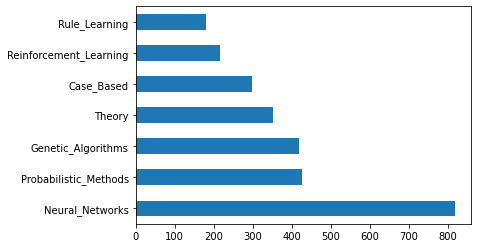

In [22]:
# the label distribution is as floows
df["label"].value_counts().plot(kind="barh")

In [23]:
# Create a new dataset using the embeddings as features
entries = []
for index, row in df.iterrows():
    node = row["node"]
    
    emb = node_embeddings[node]
    emb_dict = {"e"+str(i): emb[i] for i in range(len(emb))}
    row_dict = {**emb_dict, "label": row["label"]}
    entries.append(row_dict)
data = pd.DataFrame(entries)

In [24]:
data.head()

,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,...,e11,e12,e13,e14,e15,e16,e17,e18,e19,label
0,0.191479,0.311023,-0.247829,-0.469754,0.254492,0.234832,-0.038491,0.293307,-0.101198,-0.004308,...,0.090118,-0.336330,0.045996,-0.102616,0.048551,-0.116436,-0.173936,-0.013816,-0.020808,Rule_Learning
1,-0.217945,-0.058323,0.236630,0.023943,-0.189106,0.121669,0.278136,0.194355,0.499558,0.076719,...,0.162315,-0.020441,-0.002672,-0.098749,-0.049068,0.005267,-0.275098,-0.074772,-0.081806,Reinforcement_Learning
2,-0.207100,-0.072932,0.317803,0.082638,-0.271592,-0.045123,0.234376,0.157227,0.065088,0.011483,...,0.411574,-0.064499,0.269806,-0.196299,0.164632,-0.314928,-0.270757,-0.054850,-0.250121,Reinforcement_Learning
3,-0.001371,-0.025245,-0.065772,-0.031608,-0.129881,0.046065,0.064605,-0.085902,-0.003983,-0.223578,...,-0.008052,-0.331785,0.089208,-0.308538,-0.228122,0.262721,0.251121,0.290651,0.033639,Probabilistic_Methods
4,-0.057955,0.053605,0.305894,-0.173810,0.172788,-0.199305,-0.161851,-0.179418,0.068679,0.428615,...,0.022397,-0.151860,0.272162,0.021147,-0.307955,0.064091,-0.060214,-0.185168,0.294706,Probabilistic_Methods


In [25]:
X = data.drop("label", axis=1)
y = data["label"]

## Train some simple models

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [27]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy: ", acc(y_pred, y_test))

In [47]:
model_logreg = LogisticRegression(C=1)
model_rf = RandomForestClassifier(max_depth=20, random_state=0)

In [48]:
train_and_evaluate(model_logreg, X_train, X_test, y_train, y_test)

Accuracy:  0.7324723247232472


In [49]:
train_and_evaluate(model_rf, X_train, X_test, y_train, y_test)

Accuracy:  0.8044280442804428
